<a href="https://colab.research.google.com/github/roeyrach/NonoGram/blob/master/NonoGramNoteBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pytorch torchvision cpuonly -c pytocrch
!pip install easyocr
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 8.6 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [13]:
import cv2
import numpy as np
import easyocr
import pytesseract

In [30]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


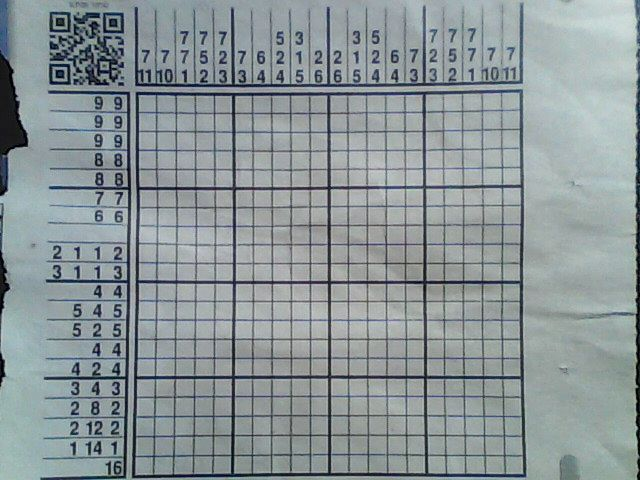

In [81]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

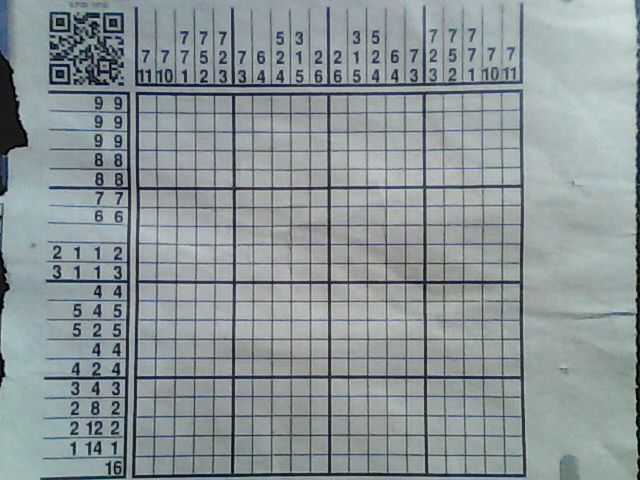

In [91]:
from google.colab.patches import cv2_imshow
img = cv2.imread("photo.jpg")
cv2_imshow(img)

In [47]:
heightImg = 450
widthImg = 450

flag = False


class Line:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.m = -(p2[1] - p1[1]) / (p2[0] - p1[0])
        self.b = (-p1[1]) - self.m * p1[0]

    def getY(self, x):
        return -(self.m * x + self.b)

    def distance(self):
        return np.sqrt((self.p1[0] - self.p2[0]) ** 2 + (self.p1[1] - self.p2[1]) ** 2)


def swap(my_points, i1, i2):
    tmp = my_points[i1].copy()
    my_points[i1] = my_points[i2]
    my_points[i2] = tmp


def scale_image(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    return img


def pre_process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE
    img = cv2.GaussianBlur(img, (3, 3), 0)  # ADD GAUSSIAN BLUR
    img = cv2.adaptiveThreshold(img, 255, 1, 1, 11, 2)  # APPLY ADAPTIVE THRESHOLD
    return img


def pre_process_text_img(img):
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = cv2.medianBlur(img, 5)
    return img


def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area


def reorder(my_points):
    my_points = np.array(my_points)[0]
    my_points = my_points.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = my_points.sum(1)
    myPointsNew[0] = my_points[np.argmin(add)]
    myPointsNew[3] = my_points[np.argmax(add)]
    diff = np.diff(my_points, axis=1)
    myPointsNew[1] = my_points[np.argmin(diff)]
    myPointsNew[2] = my_points[np.argmax(diff)]
    return myPointsNew


def reorder_left(my_points):
    l1 = Line(my_points[0][0], my_points[1][0])
    l2 = Line(my_points[2][0], my_points[3][0])
    my_points[3][0][1] = l2.getY(0)
    my_points[1][0][1] = l1.getY(0)
    my_points[1][0][0] = 0
    my_points[3][0][0] = 0
    swap(my_points, 1, 3)
    swap(my_points, 0, 2)
    upper_line = Line(my_points[2][0], my_points[3][0])
    lower_line = Line(my_points[0][0], my_points[1][0])
    if lower_line.distance() < upper_line.distance():
        my_points[3][0][0] = my_points[2][0][0] - lower_line.distance() * np.cos(np.tanh(upper_line.m))
        my_points[3][0][1] = upper_line.getY(my_points[3][0][0])
    else:
        my_points[1][0][0] = my_points[0][0][0] - upper_line.distance() * np.cos(np.tanh(lower_line.m))
        my_points[1][0][1] = lower_line.getY(my_points[1][0][0])


def get_side_picture(img, side):
    img = pre_process(img)
    if side == "left":
        pass
    elif side == "up":
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        print("you have to enter side (left | up)")
    ret, img = cv2.threshold(img, 127, 255, 0)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest_con = biggest_contour(contours)
    biggest_con = reorder(biggest_con)
    reorder_left(biggest_con)
    pts1 = np.float32(biggest_con)  # PREPARE POINTS FOR WARP
    pts2 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])  # PREPARE POINTS FOR WARP
    matrix = cv2.getPerspectiveTransform(pts1, pts2)  # GER
    img_warp = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    img = cv2.flip(img_warp, 0)
    img = cv2.flip(img, 1)
    edges = cv2.Canny(img, 50, 150, apertureSize=3)
    # Apply HoughLinesP method to
    # to directly obtain line end points
    lines = cv2.HoughLinesP(
        edges,  # Input edge image
        1,  # Distance resolution in pixels
        np.pi / 180,  # Angle resolution in radians
        threshold=100,  # Min number of votes for valid line
        minLineLength=10,  # Min allowed length of line
        maxLineGap=8  # Max allowed gap between line for joining them
    )

    # Iterate over points
    min_x = np.inf
    for points in lines:
        # Extracted points nested in the list
        x1, y1, x2, y2 = points[0]
        min_x = min(x1, x2, min_x)
    img = img[0:, min_x:]
    if side == "up":
       img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img


def get_pics_rows(img):
    return img


def capture_cam():
    cam = cv2.VideoCapture(0)
    black = np.zeros((450, 450), dtype=np.float32)
    left = cv2.cvtColor(black, cv2.COLOR_GRAY2BGR)
    up = cv2.cvtColor(black, cv2.COLOR_GRAY2BGR)
    while True:
        ret_val, video = cam.read()
        video = cv2.resize(video, (450, 450))
        try:
            left = get_side_picture(video, "left")
            up = get_side_picture(video, "up")
        except:
            if len(left.shape) == 2:
                left = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
            video1 = np.concatenate((video, left), axis=1)
            cv2.imshow('cam', video1)
        else:
            left = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
            video2 = np.concatenate((video, left), axis=1)
            cv2.imshow('cam', video2)
        if cv2.waitKey(1) & 0xFF == ord('p'):
            break
        if cv2.waitKey(1) & 0xFF == ord('s'):
            img_to_list_numbers(left, up)
            # try:
            #     img_to_list_numbers(left, up)
            # except Exception as e:
            #     print(e)
            #     print("couldn't find the numbers")
    cam.release()
    cv2.destroyAllWindows()


def recognize_text(img_path):
    reader = easyocr.Reader(['en'])
    return reader.readtext(img_path)


def img_to_list_numbers(left, up):
    left_numbers = recognize_text(left)
    up_numbers = cv2.rotate(up, cv2.ROTATE_90_CLOCKWISE)
    up_numbers = recognize_text(up_numbers)
    for (bbox, text, prob) in left_numbers:
        if prob >= 0.5:
            print(f'left side: {text} (Probability: {prob:.2f})')
    print()
    print()
    for (bbox, text, prob) in up_numbers:
        if prob >= 0.5:
            print(f'right side: {text} (Probability: {prob:.2f})')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


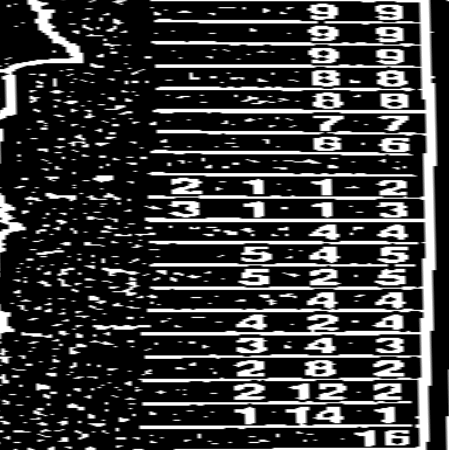

In [92]:
up = get_side_picture(img, "up")
left = get_side_picture(img, "left")
cv2_imshow(left)

[]


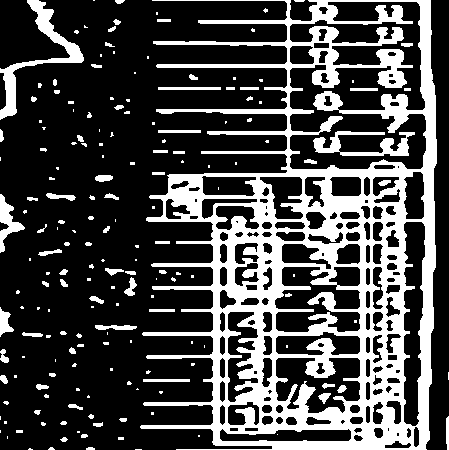

In [102]:

left = pre_process_text_img(left)
# img = scale_image(img, 150)
reader = easyocr.Reader(['en'], gpu=False)
result = reader.readtext(left)
print(result)
font = cv2.FONT_HERSHEY_SIMPLEX
for con in result:
  con_ = con[0]
  print(con[1])
  cv2.rectangle(left, (int(con_[0][0]), int(con_[0][1])), (int(con_[2][0]), int(con_[2][1])), (255,0,0), 2)
  cv2.putText(left, text=con[1], org=(int(con_[0][0]), int(con_[0][1])), color=(0,255,0), thickness=2, fontFace=font, fontScale=1, lineType=cv2.LINE_AA)
cv2_imshow(left)